In [4]:
import collections
import time

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from lib.data import DATA_PATH, get_features_and_target_from_csv
from lib.embedding_sum import EmbeddingSumClassifier

In [5]:
X_train, y_train = get_features_and_target_from_csv(DATA_PATH / 'train.csv')
X_test, y_test = get_features_and_target_from_csv(DATA_PATH / 'test.csv')

# Benchmarking

In [6]:
proposed_model_params = dict(
    max_bins=20,
    max_epochs=1000,
    lr=10,
)

models = {
    'Gaussian naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'decision tree': DecisionTreeClassifier(max_depth=4),
    'LDA': LinearDiscriminantAnalysis(),
    'logistic regression': make_pipeline(
        StandardScaler(),
        LogisticRegression(),
    ),
    'SVM': make_pipeline(
        StandardScaler(),
        SVC(probability=True),
    ),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(n_estimators=100),
    'proposed model without regularization': EmbeddingSumClassifier(
        step_loss_weight=0,
        embedding_sum_loss_weight=0,
        **proposed_model_params,
    ),
    'proposed model with sum regularization only': EmbeddingSumClassifier(
        step_loss_weight=0,
        embedding_sum_loss_weight=0.01,
        **proposed_model_params,
    ),
    'proposed model with step regularization only': EmbeddingSumClassifier(
        step_loss_weight=0.01,
        embedding_sum_loss_weight=0,
        **proposed_model_params,
    ),
    'proposed model with full regularization': EmbeddingSumClassifier(
        step_loss_weight=0.01,
        embedding_sum_loss_weight=0.01,
        **proposed_model_params,
    ),
}

metrics = collections.defaultdict(dict)

for model_name, model in models.items():
    print("Running %s" % model_name)
    start = time.perf_counter()
    model.fit(X_train, y_train)
    metrics['training time'][model_name] = time.perf_counter() - start

Running Gaussian naive Bayes
Running KNN
Running decision tree
Running LDA
Running logistic regression
Running SVM
Running Random Forest
Running XGBoost
Running proposed model without regularization
Running proposed model with sum regularization only
Running proposed model with step regularization only
Running proposed model with full regularization


In [7]:
for model_name, model in models.items():
    print("Running %s" % model_name)
    start = time.perf_counter()
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics['evaluation time'][model_name] = time.perf_counter() - start

    metrics['average precision'][model_name] = average_precision_score(y_test, y_proba)
    metrics['ROC AUC'][model_name] = roc_auc_score(y_test, y_proba)

    thresholds = np.linspace(0.001, 1, num=100, endpoint=False)

    threshold_recall90_candidates = list(filter(lambda t: recall_score(y_test, y_proba > t) >= .9, thresholds))
    if threshold_recall90_candidates:
        threshold_recall90 = max(threshold_recall90_candidates, key=lambda t: precision_score(y_test, y_proba > t))
        metrics['max precision for recall >90%'][model_name] = precision_score(y_test, y_proba > threshold_recall90)
    else:
        metrics['max precision for recall >90%'][model_name] = None

    threshold_precision90_candidates = list(filter(lambda t: precision_score(y_test, y_proba > t) >= .9, thresholds))
    if threshold_precision90_candidates:
        threshold_precision90 = max(threshold_precision90_candidates, key=lambda t: recall_score(y_test, y_proba > t))
        metrics['max recall for precision >90%'][model_name] = recall_score(y_test, y_proba > threshold_precision90)
    else:
        metrics['max recall for precision >90%'][model_name] = None


(
    pd.DataFrame(metrics)
    .style
    .format('{:.3%}', subset=['average precision', 'ROC AUC', 'max precision for recall >90%', 'max recall for precision >90%'], na_rep='n/a')
    .background_gradient(vmin=0.99, vmax=1, subset=['average precision', 'ROC AUC'])
    .background_gradient(vmin=0.98, vmax=1, subset=['max precision for recall >90%', 'max recall for precision >90%'])
)


Running Gaussian naive Bayes
Running KNN
Running decision tree
Running LDA
Running logistic regression
Running SVM
Running Random Forest
Running XGBoost
Running proposed model without regularization
Running proposed model with sum regularization only
Running proposed model with step regularization only
Running proposed model with full regularization


,training time,evaluation time,average precision,ROC AUC,max precision for recall >90%,max recall for precision >90%
Gaussian naive Bayes,0.017253,0.017614,87.370%,98.010%,63.959%,n/a
KNN,0.073348,0.775814,96.770%,98.607%,99.111%,97.351%
decision tree,0.087985,0.002137,99.225%,99.910%,98.310%,98.750%
LDA,0.024638,0.002166,98.748%,99.757%,98.987%,93.720%
logistic regression,0.045341,0.003252,99.428%,99.716%,100.000%,99.167%
SVM,4.970328,0.666426,99.942%,99.981%,100.000%,99.911%
Random Forest,2.188236,0.064308,99.959%,99.994%,100.000%,99.970%
XGBoost,0.087548,0.006252,99.349%,99.526%,99.969%,99.137%
proposed model without regularization,41.510552,0.009178,99.632%,99.937%,99.443%,99.196%
proposed model with sum regularization only,41.670751,0.007729,99.633%,99.938%,99.445%,99.196%


In [21]:
# Calculate combined score for each model
combined_scores = {
    model_name: (metrics['average precision'][model_name] + metrics['ROC AUC'][model_name]) / 2
    for model_name in models.keys()
}

# Print combined scores for all models
for model_name, combined_score in combined_scores.items():
    print(f"Model: {model_name} with combined score: {combined_score:.3%}")
print("\n")

# Find the best model based on the combined score
best_model_name = max(combined_scores, key=combined_scores.get)
best_model_score = combined_scores[best_model_name]

# Print the best model and its combined score
print(f"Best model: {best_model_name} with combined score: {best_model_score:.3%}")

Model: Gaussian naive Bayes with combined score: 92.690%
Model: KNN with combined score: 97.689%
Model: decision tree with combined score: 99.568%
Model: LDA with combined score: 99.252%
Model: logistic regression with combined score: 99.572%
Model: SVM with combined score: 99.962%
Model: Random Forest with combined score: 99.977%
Model: XGBoost with combined score: 99.437%
Model: proposed model without regularization with combined score: 99.785%
Model: proposed model with sum regularization only with combined score: 99.785%
Model: proposed model with step regularization only with combined score: 99.825%
Model: proposed model with full regularization with combined score: 99.826%


Best model: Random Forest with combined score: 99.977%


# Interpretability

In [8]:
(
    pd.DataFrame(X_train)
    .corrwith(y_train).rename('target correlation').to_frame()
    .assign(**{
        'logistic regression coefficient': models['logistic regression'][-1].coef_.flatten(),
    })
    .style
    .background_gradient(vmin=-.6, vmax=.6, cmap='bwr', subset='target correlation')
    .background_gradient(vmin=-5, vmax=5, cmap='bwr', subset='logistic regression coefficient')
)

,target correlation,logistic regression coefficient
FEC:NotifyFileWasCreated,0.164840,-0.086363
FEC:NotifyFileWasDeleted,0.063458,-0.160608
FEC:NotifyFileWasRead,0.613613,1.290595
FEC:NotifyFileWasRenamed,0.691445,1.908892
FEC:NotifyFileWasWritten,0.584616,-0.647862
REC:NotifyCreateKeyEx,0.626611,9.648694
REC:NotifyEnumerateKey,0.355050,-0.757473
REC:NotifyEnumerateValueKey,0.237110,-0.789900
REC:NotifyQueryKey,0.374497,0.206850
REC:NotifyQueryMultipleValueKey,0.540007,2.892877


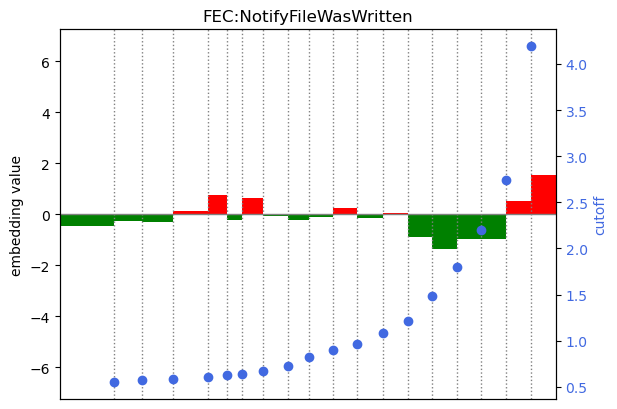

In [9]:
models['proposed model without regularization'].visualize(feature_names=X_train.columns,
                                                          subset=['FEC:NotifyFileWasWritten'])

# Regularization

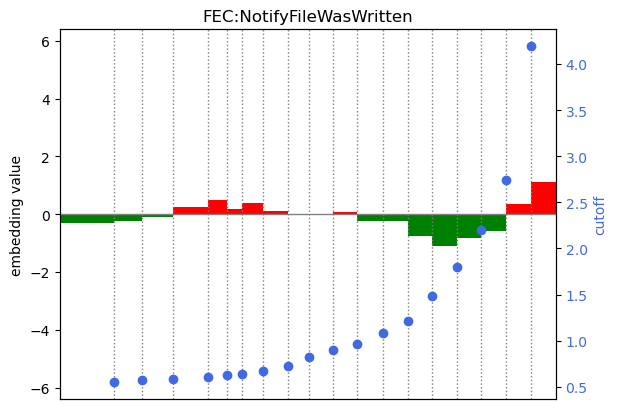

In [10]:
models['proposed model with full regularization'].visualize(feature_names=X_train.columns,
                                                            subset=['FEC:NotifyFileWasWritten'])

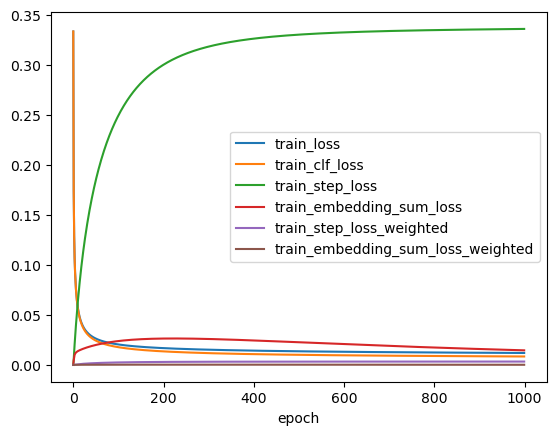

In [11]:
models['proposed model with full regularization'].plot_training_history()

# Feature importance

In [12]:
(
    pd.DataFrame({
        ('feature importance', name): models[name].feature_importance(feature_names=X_train.columns)
        for name
        in [
            'proposed model without regularization',
            'proposed model with full regularization',
        ]
    })
    .sort_values(by=('feature importance', 'proposed model without regularization'), ascending=False)
    .style
    .bar()
)

# Interpretability - all features

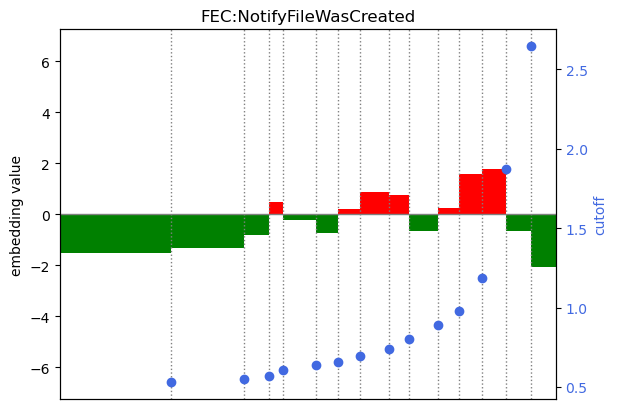

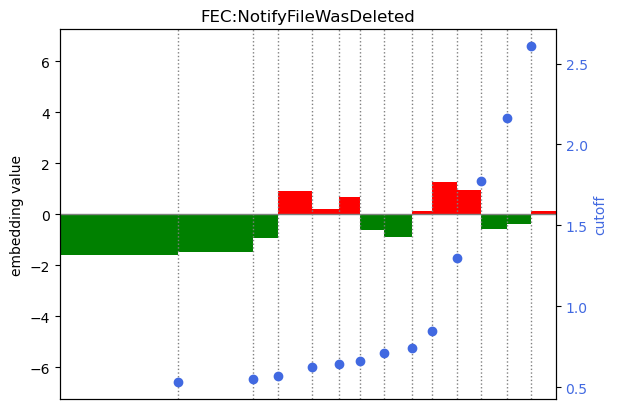

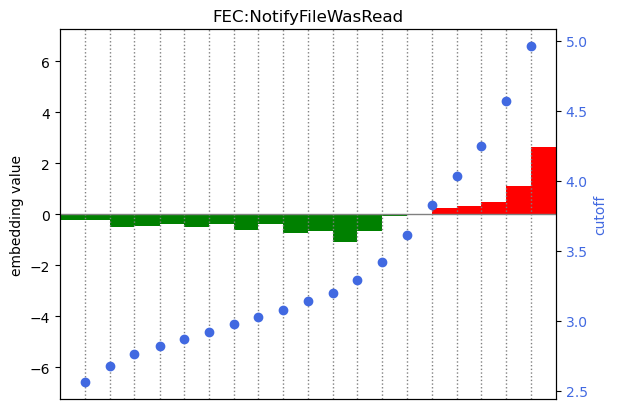

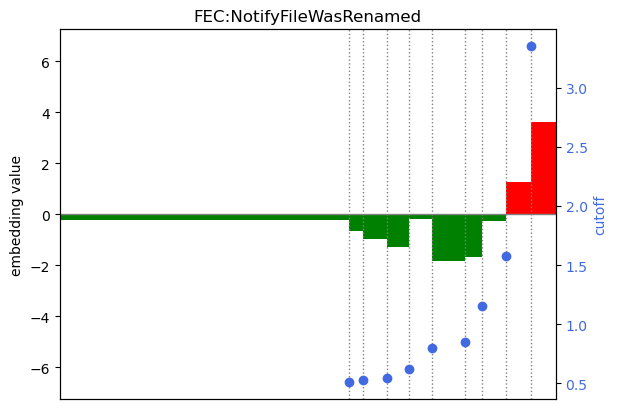

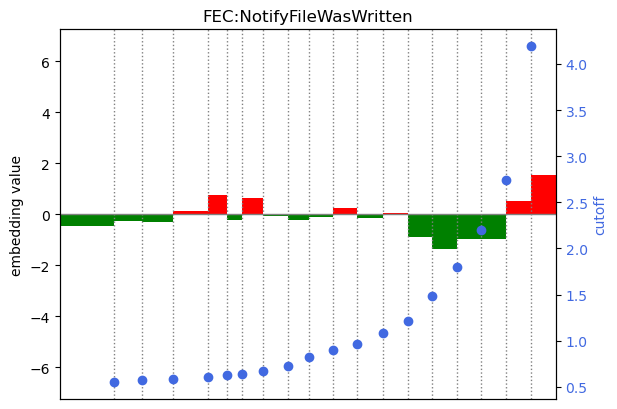

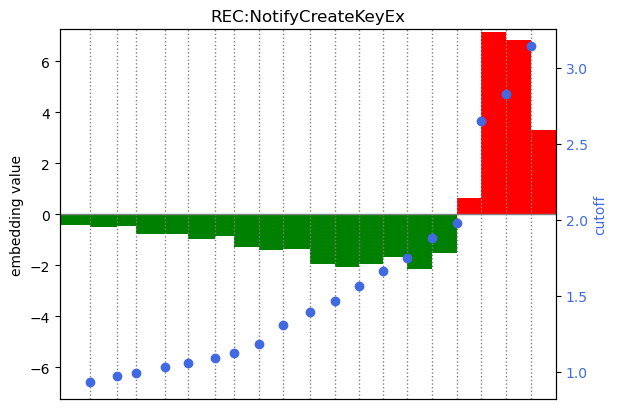

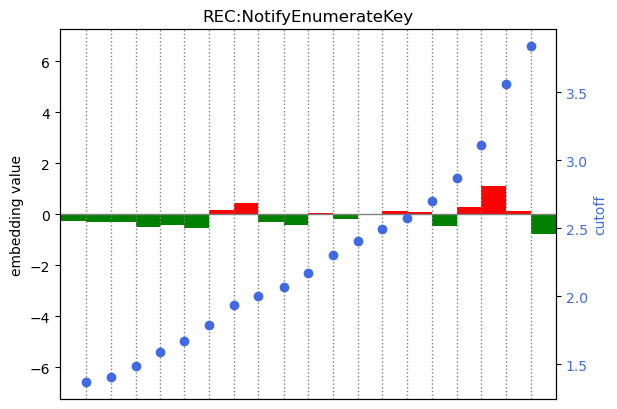

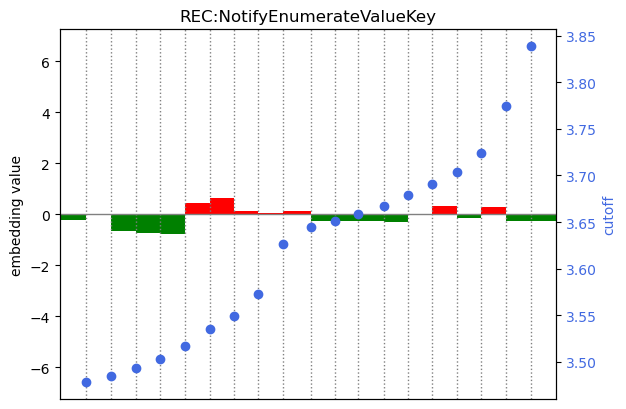

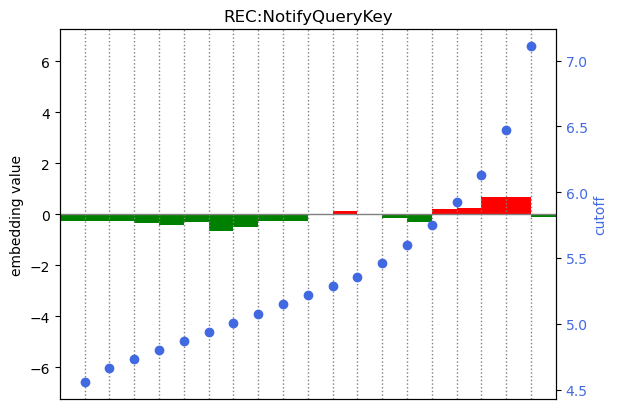

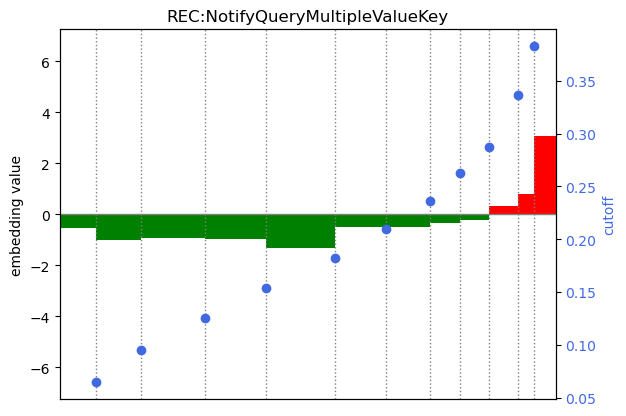

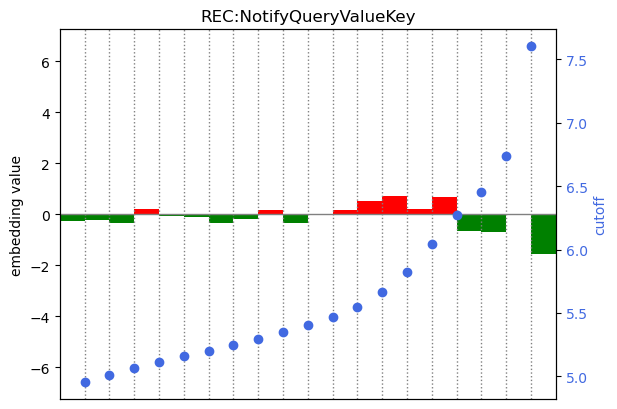

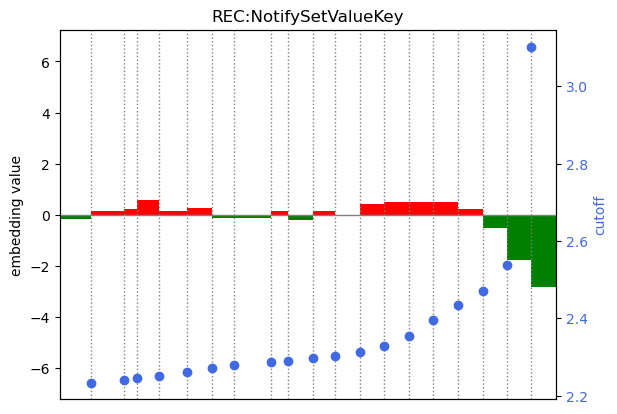

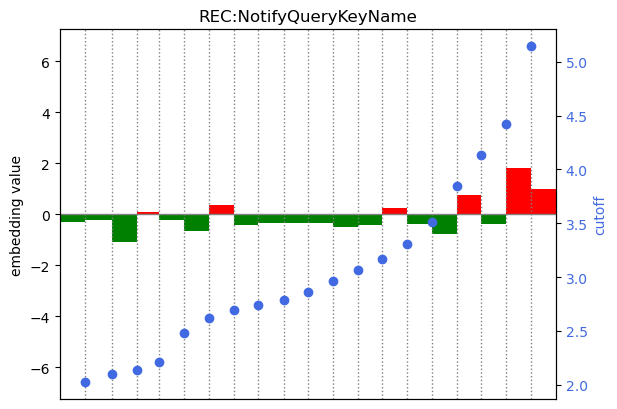

In [13]:
models['proposed model without regularization'].visualize(feature_names=X_train.columns)

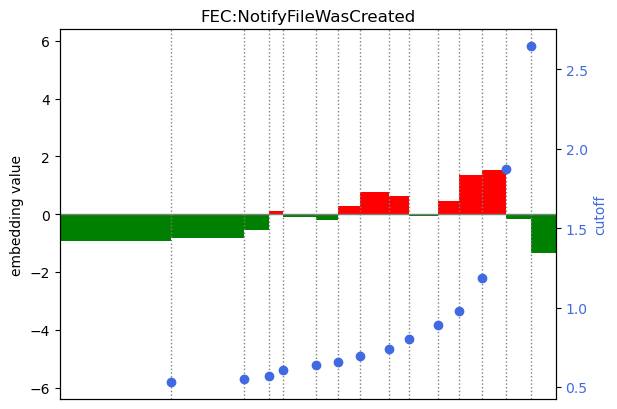

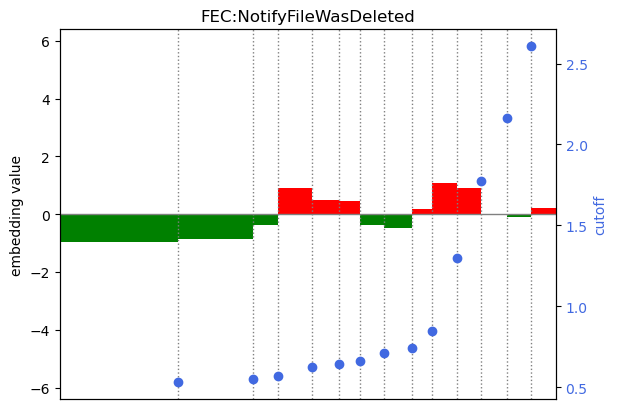

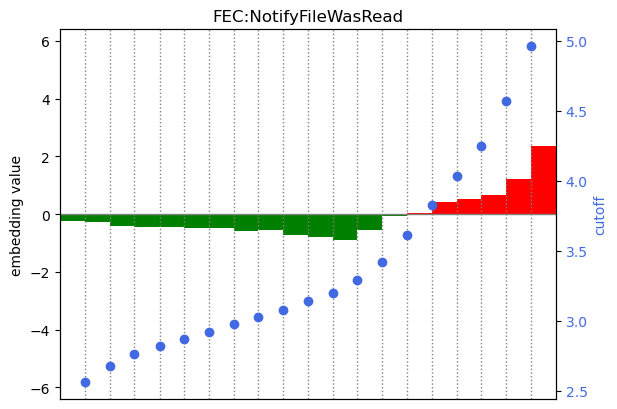

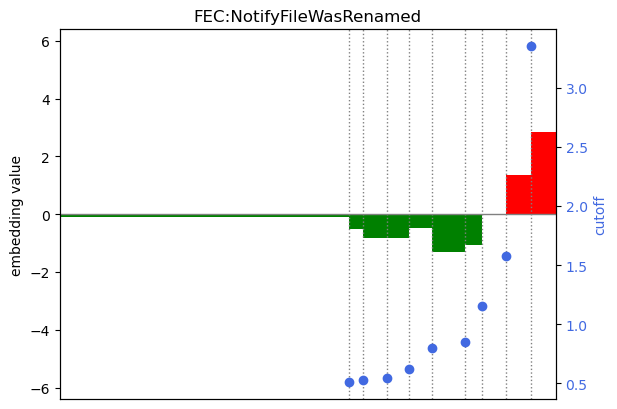

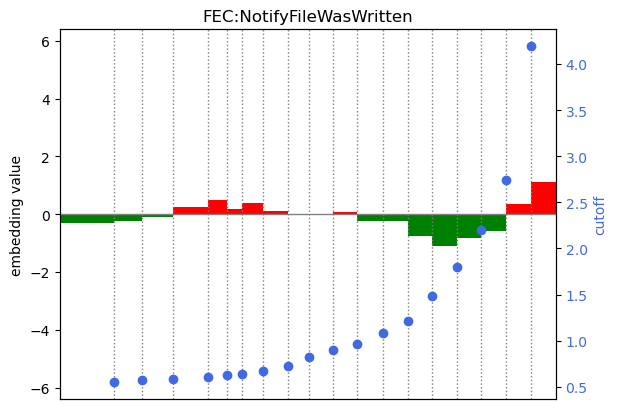

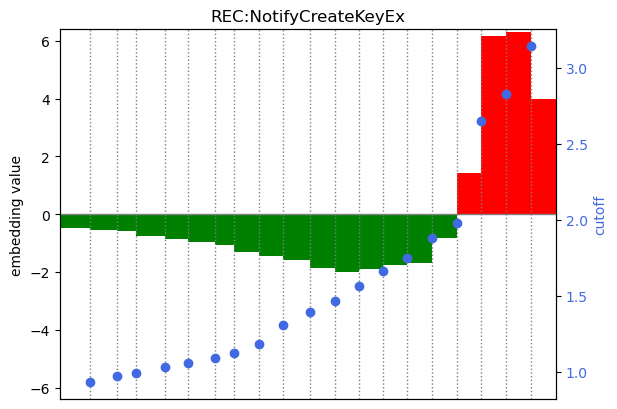

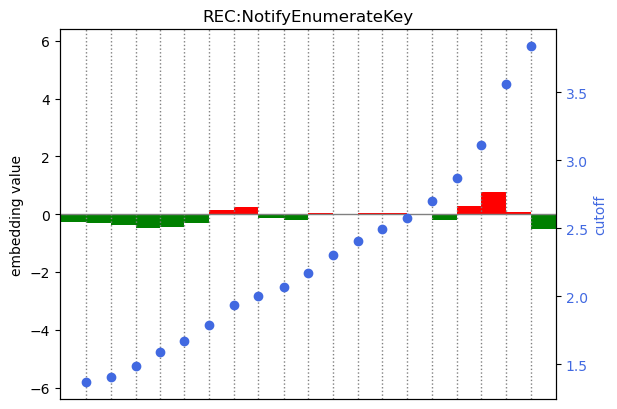

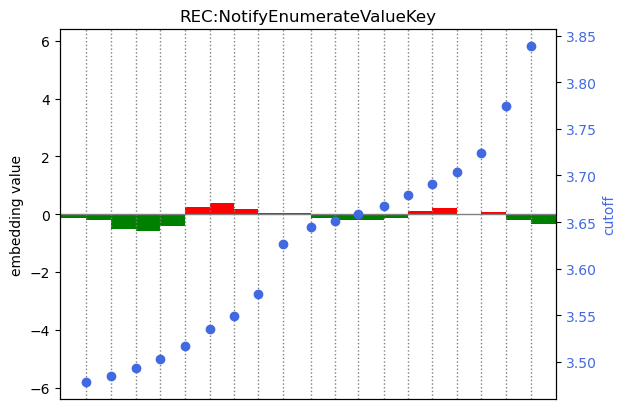

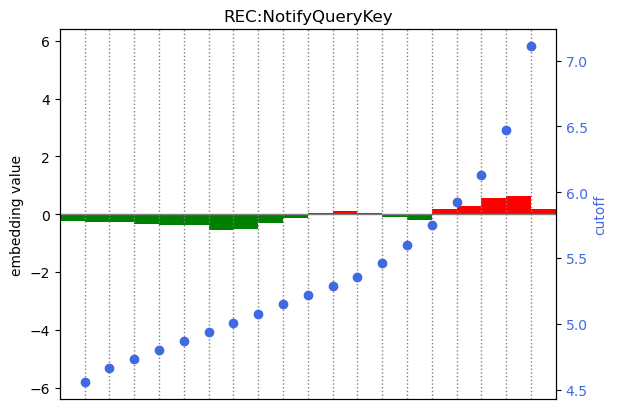

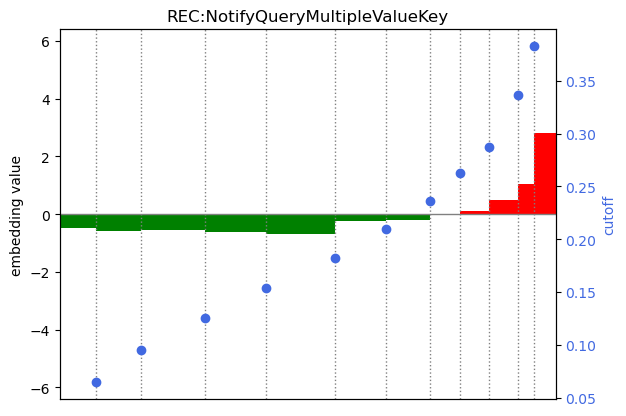

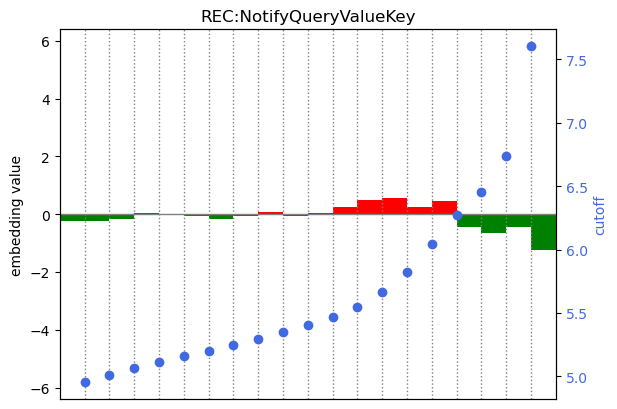

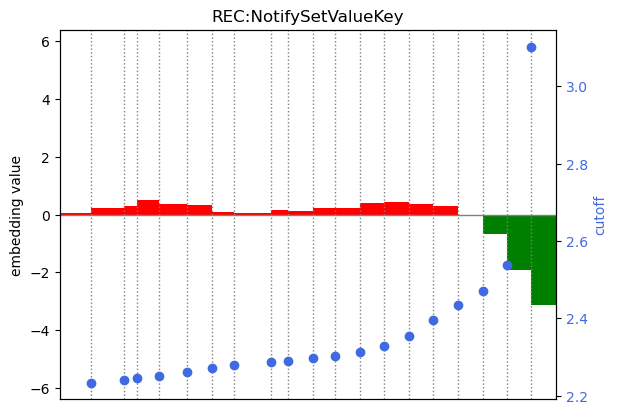

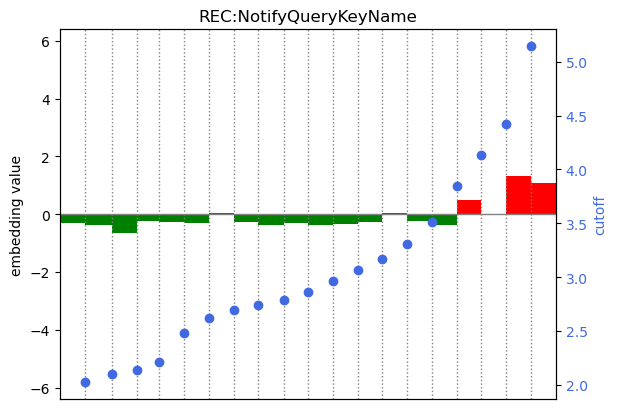

In [14]:
models['proposed model with full regularization'].visualize(feature_names=X_train.columns)